# Лабораторная работа №1 (Методы нулевого порядка)

*Широких Николай Александрович*

*Коршунов Илья Константинович*

#### Задача
Задача этой работы – реализовать методы оптимизации и исследовать сравнить их эффективность в разных ситуациях.

## Основной код

In [1]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import scipy
import numpy as np
import sympy as sp
import pandas as pd

import inspect
from IPython import display
import random
from functools import partial

mpl.rcParams["figure.dpi"] = 200
DEFAULT_EPS = 1e-3
GLOBAL_MIN = {}

In [2]:
class util:
    def lambdify(f):
        return f if callable(f) else sp.lambdify(tuple(f.free_symbols), f)

    def call_counted(f):
        def wrapped(*args, **kwargs):
            wrapped.calls += 1
            return f(*args, **kwargs)

        wrapped.calls = 0
        return wrapped

    def grad(f):
        vector = tuple(f.diff(var) for var in f.free_symbols)
        return lambda point: np.array(
            list(map(lambda var: float(var.subs(zip(f.free_symbols, point))), vector))
        )

    def is_3d(f):
        return len(inspect.signature(util.lambdify(f)).parameters) == 2

    def format_point(point):
        if point is None:
            return "none"
        if all(isinstance(p, int) for p in point):
            return ", ".join(str(p) for p in point)
        return ", ".join(f"{p:.2e}" for p in point)

In [3]:
class plotter:
    def __init__(self, f) -> None:
        self.f = util.lambdify(f)

    def figure(self, angle=(45, 15), figsize=(14, 7)):
        fig = plt.figure(figsize=figsize)
        self.ax3d = fig.add_subplot(121, projection="3d")
        self.ax3d.set_axis_off()

        self.axc = fig.add_subplot(122)
        self.ax3d.view_init(*angle)
        return self

    def plot3d(self, center=(0, 0), radius=1):
        X = np.linspace(center[0] - radius, center[0] + radius, 100)
        Y = np.linspace(center[1] - radius, center[1] + radius, 100)
        X, Y = np.meshgrid(X, Y)
        Z = self.f(X, Y)
        self.ax3d.plot_surface(X, Y, Z, alpha=0.45, cmap="viridis", edgecolor="none")
        self.axc.contour(X, Y, Z, 25)
        return self

    def plot_steps(self, points, colors="red", l=None):
        points = np.array(points)
        X, Y = points[:, 0], points[:, 1]
        Z = self.f(X, Y)

        self.ax3d.plot(
            X, Y, Z, color=colors, linewidth=1, marker="o", markersize=2, label=l
        )
        self.axc.plot(X, Y, marker="o", linewidth=1, markersize=2, color=colors)

        if l is not None:
            self.ax3d.legend(loc="upper right")
        return self

In [4]:
class search1d:
    def dichotomies(f, a, b, eps=DEFAULT_EPS):
        f = util.lambdify(f)
        while b - a > eps:
            mid = (a + b) / 2
            f_mid = f(mid)
            l_mid = (a + mid) / 2
            fl_mid = f(l_mid)
            if fl_mid < f_mid:
                b = mid
            else:
                r_mid = (mid + b) / 2
                fr_mid = f(r_mid)
                if fr_mid < f_mid:
                    a = mid
                else:
                    a = l_mid
                    b = r_mid

        return mid

    def golden_section(f, a, b, eps=DEFAULT_EPS):
        T = (1 + 5**0.5) / 2
        f = util.lambdify(f)

        f_left = f(a + (b - a) / T)
        f_right = f(b - (b - a) / T)

        while b - a > eps:
            if f_right > f_left:
                a = b - (b - a) / T
                f_right = f_left
                f_left = f(a + (b - a) / T)
            else:
                b = a + (b - a) / T
                f_left = f_right
                f_right = f(b - (b - a) / T)

        return (a + b) / 2


search1d.dichotomies.name = "dichotomies"
search1d.golden_section.name = "golden section"

In [5]:
class minimize_result:
    def __init__(
        self, func, opt, iterations, calls, steps, eps, start, method
    ) -> None:
        self.func = func
        self.opt = opt
        self.iterations = iterations
        self.calls = calls
        self.steps = steps
        self.eps = eps
        self.start = start
        self.method = method
        if self.success():
            if func in GLOBAL_MIN:
                self.deviation = np.linalg.norm(np.array(opt) - GLOBAL_MIN[func])
                self.deviation = util.format_point((self.deviation,))
            else:
                self.deviation = "unknown"
        else:
            self.deviation = float("inf")

    def cols():
        return [
            "func",
            "start point",
            "optimum",
            "deviation",
            "iterations",
            "calls",
            "eps",
            "method",
        ]

    def row(self):
        return [
            self.func,
            util.format_point(self.start),
            util.format_point(self.opt),
            self.deviation,
            self.iterations,
            self.calls,
            self.eps,
            self.method,
        ]

    def success(self) -> bool:
        return self.opt is not None

In [6]:
class gradient_step:
    def leaning_rate(lr):
        def next_step(f, x, S_k, eps):
            return x + lr * S_k

        next_step.name = f"lr {lr}"
        return next_step

    def search(s=search1d.golden_section):
        def next_step(f, x, S_k, eps):
            alpha = s(lambda alpha: f(*(x + alpha * S_k)), 0, 1, eps=eps)
            return x + alpha * S_k

        next_step.name = "with " + s.name
        return next_step


class gradient_stop:
    def by_coord():
        stop = lambda f, x_k, x, eps: np.linalg.norm(x_k - x) < eps
        stop.name = "stop by coord"
        return stop
    
    def by_value():
        stop = lambda f, x_k, x, eps: abs(f(*x_k) - f(*x)) < eps
        stop.name = "stop by value"
        return stop

In [7]:
class minimize:
    def gradient(
        f,
        x0,
        eps=DEFAULT_EPS,
        maxiter=1000,
        next_step=gradient_step.search(),
        stop=gradient_stop.by_coord(),
    ):
        count = 0
        opt = np.array(x0)
        fast_f = util.call_counted(util.lambdify(f))
        grad_f = util.call_counted(util.grad(f))
        points = None
        if util.is_3d(fast_f):
            points = [opt]

        while True:
            if count >= maxiter:
                opt = None
                count = f">{count}"
                points = None
                break
            S_k = -grad_f(opt)
            x_k = next_step(fast_f, opt, S_k, eps)
            if points is not None:
                points.append(x_k)
            points.append(x_k)
            if stop(fast_f, x_k, opt, eps):
                opt = x_k
                break
            opt = x_k
            count += 1

        calls = fast_f.calls + grad_f.calls
        name = "gradient " + next_step.name + " " + stop.name
        return minimize_result(f, opt, count, calls, points, eps, x0, name)

    def nelder_mead(f, x0, eps=DEFAULT_EPS, maxiter=1000):
        g = util.lambdify(f)
        h = lambda x: float(g(*x))
        points = None
        callback = None
        if util.is_3d(f):
            points = [x0]
            callback = lambda xk: points.append(xk)

        result = scipy.optimize.minimize(
            h,
            x0,
            method="Nelder-Mead",
            callback=callback,
            options={"xatol": eps, "maxiter": maxiter},
        )

        if not result.success:
            result.x = None
            result.nit = f">{result.nit}"
        return minimize_result(
            f, result.x, result.nit, result.nfev, points, eps, x0, "nelder mead"
        )

In [8]:
class Table:
    def __init__(self, columns=minimize_result.cols()) -> None:
        self.table = pd.DataFrame(columns=columns)

    def add_row(self, row):
        convert_sympy = lambda expr: (
            expr if not isinstance(expr, sp.Expr) else "$" + sp.latex(expr) + "$"
        )
        self.table.loc[len(self.table)] = list(map(convert_sympy, row))
        return self

    def display(self):
        display.display(display.Markdown(self.table.to_markdown()))

## Отчёт

### Основная часть

Для основной части давайте рассмотрим следующие функции:
1) $ f(x, y) = x^2 + y^2 $
2) $ f(x, y) = x^2 + y^2 - x y + 2 x - 4  y + 3$


In [9]:
f1 = sp.sympify("x**2 + y**2")
f2 = sp.sympify("x**2 + y**2 - x*y + 2*x - 4*y + 3")

GLOBAL_MIN[f1] = np.array([0, 0])
GLOBAL_MIN[f2] = np.array([0, 2])


Мы протестировали данные функции на следующий методах:
1) Метод градиентонго спуска с постоянным шагом
2) Метод градиентного спуска на основе одномерного поиска методом дихотомии и золотого сечения
3) Метод Нелдера-Мида


#### Метод градиентного спуска с постоянным шагом

In [10]:
gradient_steps = [gradient_step.leaning_rate(lr) for lr in [0.3, 0.7, 0.9]]
minimize_functions = [partial(minimize.gradient, next_step=f) for f in gradient_steps]

for f in [f1, f2]:
    table = Table()
    for point in [(0, 1), (3, 5), (7, 9)]:
        for minimize_func in minimize_functions:
            for eps in [0.01, 0.001, 0.0001]:
                result = minimize_func(f, point, eps)
                table.add_row(result.row())
    table.display()

|    | func            | start point   | optimum              |   deviation |   iterations |   calls |    eps | method                        |
|---:|:----------------|:--------------|:---------------------|------------:|-------------:|--------:|-------:|:------------------------------|
|  0 | $x^{2} + y^{2}$ | 0, 1          | 0.00e+00, 4.10e-03   |    0.0041   |            5 |       6 | 0.01   | gradient lr 0.3 stop by coord |
|  1 | $x^{2} + y^{2}$ | 0, 1          | 0.00e+00, 6.55e-04   |    0.000655 |            7 |       8 | 0.001  | gradient lr 0.3 stop by coord |
|  2 | $x^{2} + y^{2}$ | 0, 1          | 0.00e+00, 4.19e-05   |    4.19e-05 |           10 |      11 | 0.0001 | gradient lr 0.3 stop by coord |
|  3 | $x^{2} + y^{2}$ | 0, 1          | 0.00e+00, -1.64e-03  |    0.00164  |            6 |       7 | 0.01   | gradient lr 0.7 stop by coord |
|  4 | $x^{2} + y^{2}$ | 0, 1          | 0.00e+00, -2.62e-04  |    0.000262 |            8 |       9 | 0.001  | gradient lr 0.7 stop by coord |
|  5 | $x^{2} + y^{2}$ | 0, 1          | 0.00e+00, 1.68e-05   |    1.68e-05 |           11 |      12 | 0.0001 | gradient lr 0.7 stop by coord |
|  6 | $x^{2} + y^{2}$ | 0, 1          | 0.00e+00, -3.78e-03  |    0.00378  |           24 |      25 | 0.01   | gradient lr 0.9 stop by coord |
|  7 | $x^{2} + y^{2}$ | 0, 1          | 0.00e+00, -4.06e-04  |    0.000406 |           34 |      35 | 0.001  | gradient lr 0.9 stop by coord |
|  8 | $x^{2} + y^{2}$ | 0, 1          | 0.00e+00, -4.36e-05  |    4.36e-05 |           44 |      45 | 0.0001 | gradient lr 0.9 stop by coord |
|  9 | $x^{2} + y^{2}$ | 3, 5          | 1.97e-03, 3.28e-03   |    0.00382  |            7 |       8 | 0.01   | gradient lr 0.3 stop by coord |
| 10 | $x^{2} + y^{2}$ | 3, 5          | 3.15e-04, 5.24e-04   |    0.000611 |            9 |      10 | 0.001  | gradient lr 0.3 stop by coord |
| 11 | $x^{2} + y^{2}$ | 3, 5          | 2.01e-05, 3.36e-05   |    3.91e-05 |           12 |      13 | 0.0001 | gradient lr 0.3 stop by coord |
| 12 | $x^{2} + y^{2}$ | 3, 5          | -7.86e-04, -1.31e-03 |    0.00153  |            8 |       9 | 0.01   | gradient lr 0.7 stop by coord |
| 13 | $x^{2} + y^{2}$ | 3, 5          | -1.26e-04, -2.10e-04 |    0.000245 |           10 |      11 | 0.001  | gradient lr 0.7 stop by coord |
| 14 | $x^{2} + y^{2}$ | 3, 5          | 8.05e-06, 1.34e-05   |    1.57e-05 |           13 |      14 | 0.0001 | gradient lr 0.7 stop by coord |
| 15 | $x^{2} + y^{2}$ | 3, 5          | -1.90e-03, -3.17e-03 |    0.0037   |           32 |      33 | 0.01   | gradient lr 0.9 stop by coord |
| 16 | $x^{2} + y^{2}$ | 3, 5          | -2.04e-04, -3.40e-04 |    0.000397 |           42 |      43 | 0.001  | gradient lr 0.9 stop by coord |
| 17 | $x^{2} + y^{2}$ | 3, 5          | -2.19e-05, -3.65e-05 |    4.26e-05 |           52 |      53 | 0.0001 | gradient lr 0.9 stop by coord |
| 18 | $x^{2} + y^{2}$ | 7, 9          | 1.84e-03, 2.36e-03   |    0.00299  |            8 |       9 | 0.01   | gradient lr 0.3 stop by coord |
| 19 | $x^{2} + y^{2}$ | 7, 9          | 2.94e-04, 3.77e-04   |    0.000478 |           10 |      11 | 0.001  | gradient lr 0.3 stop by coord |
| 20 | $x^{2} + y^{2}$ | 7, 9          | 1.88e-05, 2.42e-05   |    3.06e-05 |           13 |      14 | 0.0001 | gradient lr 0.3 stop by coord |
| 21 | $x^{2} + y^{2}$ | 7, 9          | 7.34e-04, 9.44e-04   |    0.0012   |            9 |      10 | 0.01   | gradient lr 0.7 stop by coord |
| 22 | $x^{2} + y^{2}$ | 7, 9          | 1.17e-04, 1.51e-04   |    0.000191 |           11 |      12 | 0.001  | gradient lr 0.7 stop by coord |
| 23 | $x^{2} + y^{2}$ | 7, 9          | -7.52e-06, -9.66e-06 |    1.22e-05 |           14 |      15 | 0.0001 | gradient lr 0.7 stop by coord |
| 24 | $x^{2} + y^{2}$ | 7, 9          | 2.27e-03, 2.92e-03   |    0.0037   |           35 |      36 | 0.01   | gradient lr 0.9 stop by coord |
| 25 | $x^{2} + y^{2}$ | 7, 9          | 2.44e-04, 3.14e-04   |    0.000397 |           45 |      46 | 0.001  | gradient lr 0.9 stop by coord |
| 26 | $x^{2} + y^{2}$ | 7, 9          | 2.62e-05, 3.37e-05   |    4.27e-05 |           55 |      56 | 0.0001 | gradient lr 0.9 stop by coord |

|    | func                                  | start point   | optimum             |   deviation | iterations   |   calls |    eps | method                        |
|---:|:--------------------------------------|:--------------|:--------------------|------------:|:-------------|--------:|-------:|:------------------------------|
|  0 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 0, 1          | -1.41e-02, 1.99e+00 |    0.02     | 9            |      10 | 0.01   | gradient lr 0.3 stop by coord |
|  1 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 0, 1          | -1.16e-03, 2.00e+00 |    0.00164  | 16           |      17 | 0.001  | gradient lr 0.3 stop by coord |
|  2 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 0, 1          | -1.37e-04, 2.00e+00 |    0.000194 | 22           |      23 | 0.0001 | gradient lr 0.3 stop by coord |
|  3 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 0, 1          | none                |  inf        | >1000        |    1000 | 0.01   | gradient lr 0.7 stop by coord |
|  4 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 0, 1          | none                |  inf        | >1000        |    1000 | 0.001  | gradient lr 0.7 stop by coord |
|  5 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 0, 1          | none                |  inf        | >1000        |    1000 | 0.0001 | gradient lr 0.7 stop by coord |
|  6 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 0, 1          | none                |  inf        | >1000        |    1000 | 0.01   | gradient lr 0.9 stop by coord |
|  7 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 0, 1          | none                |  inf        | >1000        |    1000 | 0.001  | gradient lr 0.9 stop by coord |
|  8 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 0, 1          | none                |  inf        | >1000        |    1000 | 0.0001 | gradient lr 0.9 stop by coord |
|  9 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 1.42e-02, 2.01e+00  |    0.0201   | 14           |      15 | 0.01   | gradient lr 0.3 stop by coord |
| 10 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 1.17e-03, 2.00e+00  |    0.00166  | 21           |      22 | 0.001  | gradient lr 0.3 stop by coord |
| 11 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 1.38e-04, 2.00e+00  |    0.000195 | 27           |      28 | 0.0001 | gradient lr 0.3 stop by coord |
| 12 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 2.19e-03, 2.00e+00  |    0.00309  | 5            |       6 | 0.01   | gradient lr 0.7 stop by coord |
| 13 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 1.97e-04, 2.00e+00  |    0.000278 | 7            |       8 | 0.001  | gradient lr 0.7 stop by coord |
| 14 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 1.77e-05, 2.00e+00  |    2.51e-05 | 9            |      10 | 0.0001 | gradient lr 0.7 stop by coord |
| 15 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 3.00e-04, 2.00e+00  |    0.000424 | 3            |       4 | 0.01   | gradient lr 0.9 stop by coord |
| 16 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 3.00e-05, 2.00e+00  |    4.24e-05 | 4            |       5 | 0.001  | gradient lr 0.9 stop by coord |
| 17 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 3.00e-06, 2.00e+00  |    4.24e-06 | 5            |       6 | 0.0001 | gradient lr 0.9 stop by coord |
| 18 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.63e-02, 2.02e+00  |    0.023    | 16           |      17 | 0.01   | gradient lr 0.3 stop by coord |
| 19 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.34e-03, 2.00e+00  |    0.0019   | 23           |      24 | 0.001  | gradient lr 0.3 stop by coord |
| 20 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.58e-04, 2.00e+00  |    0.000223 | 29           |      30 | 0.0001 | gradient lr 0.3 stop by coord |
| 21 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.53e-03, 2.00e+00  |    0.00217  | 6            |       7 | 0.01   | gradient lr 0.7 stop by coord |
| 22 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.38e-04, 2.00e+00  |    0.000195 | 8            |       9 | 0.001  | gradient lr 0.7 stop by coord |
| 23 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.24e-05, 2.00e+00  |    1.75e-05 | 10           |      11 | 0.0001 | gradient lr 0.7 stop by coord |
| 24 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 7.00e-04, 2.00e+00  |    0.00099  | 3            |       4 | 0.01   | gradient lr 0.9 stop by coord |
| 25 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 7.00e-05, 2.00e+00  |    9.9e-05  | 4            |       5 | 0.001  | gradient lr 0.9 stop by coord |
| 26 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 7.00e-06, 2.00e+00  |    9.9e-06  | 5            |       6 | 0.0001 | gradient lr 0.9 stop by coord |

В процессе нашего исследования мы экспериментировали с различными настройками алгоритма оптимизации, такими как точность, начальная точка, размер шага и другие параметры. В результате было обнаружено, что для относительно простых функций возможно определить оптимальный шаг, что позволяет ускорить процесс оптимизации.

Однако, если размер шага выбран неправильно, это может привести к существенному увеличению количества итераций или даже сделать невозможным достижение минимума, как будет показано далее. Такой эффект связан с тем, что при фиксированном значении шага неправильный выбор может привести к зацикливанию процесса оптимизации или слишком медленному приближению к экстремуму, поскольку величина шага в формуле $x_{k+1} = x_k - \alpha \cdot \nabla \text{grad}(x_k)$ играет ключевую роль.

Из анализа результатов, представленных в таблице, мы сделали вывод, что рассматриваемый подход особенно эффективен для "простых" функций, таких как $f1(x,y)=x^2+y^2$, у которой градиент направлен к оптимуму.

#### Градиентный спуск на основе одномерного поиска

Существует метод, который позволяет избежать выбора шага на основе простого угадывания, а именно - метод, использующий одномерный поиск. Суть этого метода заключается в том, что на каждой итерации алгоритма выполняется поиск оптимального значения шага, для которого значение целевой функции $f(x_k - \alpha \cdot \text{grad}(x_k))$ будет минимальным. Это преобразует задачу в поиск минимума функции от одного аргумента, которая, является унимодальной.

Унимодальность функции важна, поскольку она позволяет применять эффективные методы поиска минимума, такие как метод дихотомии или золотого сечения. Эти методы основаны на принципе сужения области поиска оптимального значения в фиксированное количество раз на каждом шаге итерации, что требует всего одного или двух вычислений целевой функции для каждого сужения.

In [11]:
gradient_steps = [gradient_step.leaning_rate(lr) for lr in [0.3, 0.7]]
gradient_steps += [
    gradient_step.search(s) for s in [search1d.dichotomies, search1d.golden_section]
]
minimize_functions = [partial(minimize.gradient, next_step=f) for f in gradient_steps]

for f in [f1, f2]:
    table = Table()
    for point in [(3, 5), (7, 9)]:
        for minimize_func in minimize_functions:
            for eps in [0.001, 0.0001]:
                result = minimize_func(f, point, eps)
                table.add_row(result.row())
    table.display()

|    | func            | start point   | optimum              |   deviation |   iterations |   calls |    eps | method                                     |
|---:|:----------------|:--------------|:---------------------|------------:|-------------:|--------:|-------:|:-------------------------------------------|
|  0 | $x^{2} + y^{2}$ | 3, 5          | 3.15e-04, 5.24e-04   |    0.000611 |            9 |      10 | 0.001  | gradient lr 0.3 stop by coord              |
|  1 | $x^{2} + y^{2}$ | 3, 5          | 2.01e-05, 3.36e-05   |    3.91e-05 |           12 |      13 | 0.0001 | gradient lr 0.3 stop by coord              |
|  2 | $x^{2} + y^{2}$ | 3, 5          | -1.26e-04, -2.10e-04 |    0.000245 |           10 |      11 | 0.001  | gradient lr 0.7 stop by coord              |
|  3 | $x^{2} + y^{2}$ | 3, 5          | 8.05e-06, 1.34e-05   |    1.57e-05 |           13 |      14 | 0.0001 | gradient lr 0.7 stop by coord              |
|  4 | $x^{2} + y^{2}$ | 3, 5          | 0.00e+00, 0.00e+00   |    0        |            1 |      62 | 0.001  | gradient with dichotomies stop by coord    |
|  5 | $x^{2} + y^{2}$ | 3, 5          | 0.00e+00, 0.00e+00   |    0        |            1 |      86 | 0.0001 | gradient with dichotomies stop by coord    |
|  6 | $x^{2} + y^{2}$ | 3, 5          | 0.00e+00, 0.00e+00   |    0        |            1 |      36 | 0.001  | gradient with golden section stop by coord |
|  7 | $x^{2} + y^{2}$ | 3, 5          | -4.83e-14, -8.05e-14 |    9.39e-14 |            2 |      69 | 0.0001 | gradient with golden section stop by coord |
|  8 | $x^{2} + y^{2}$ | 7, 9          | 2.94e-04, 3.77e-04   |    0.000478 |           10 |      11 | 0.001  | gradient lr 0.3 stop by coord              |
|  9 | $x^{2} + y^{2}$ | 7, 9          | 1.88e-05, 2.42e-05   |    3.06e-05 |           13 |      14 | 0.0001 | gradient lr 0.3 stop by coord              |
| 10 | $x^{2} + y^{2}$ | 7, 9          | 1.17e-04, 1.51e-04   |    0.000191 |           11 |      12 | 0.001  | gradient lr 0.7 stop by coord              |
| 11 | $x^{2} + y^{2}$ | 7, 9          | -7.52e-06, -9.66e-06 |    1.22e-05 |           14 |      15 | 0.0001 | gradient lr 0.7 stop by coord              |
| 12 | $x^{2} + y^{2}$ | 7, 9          | 0.00e+00, 0.00e+00   |    0        |            1 |      62 | 0.001  | gradient with dichotomies stop by coord    |
| 13 | $x^{2} + y^{2}$ | 7, 9          | 0.00e+00, 0.00e+00   |    0        |            1 |      86 | 0.0001 | gradient with dichotomies stop by coord    |
| 14 | $x^{2} + y^{2}$ | 7, 9          | 0.00e+00, 0.00e+00   |    0        |            1 |      36 | 0.001  | gradient with golden section stop by coord |
| 15 | $x^{2} + y^{2}$ | 7, 9          | 1.13e-13, 1.45e-13   |    1.84e-13 |            2 |      69 | 0.0001 | gradient with golden section stop by coord |

|    | func                                  | start point   | optimum            |   deviation |   iterations |   calls |    eps | method                                     |
|---:|:--------------------------------------|:--------------|:-------------------|------------:|-------------:|--------:|-------:|:-------------------------------------------|
|  0 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 1.17e-03, 2.00e+00 |    0.00166  |           21 |      22 | 0.001  | gradient lr 0.3 stop by coord              |
|  1 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 1.38e-04, 2.00e+00 |    0.000195 |           27 |      28 | 0.0001 | gradient lr 0.3 stop by coord              |
|  2 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 1.97e-04, 2.00e+00 |    0.000278 |            7 |       8 | 0.001  | gradient lr 0.7 stop by coord              |
|  3 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 1.77e-05, 2.00e+00 |    2.51e-05 |            9 |      10 | 0.0001 | gradient lr 0.7 stop by coord              |
|  4 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 1.12e-08, 2.00e+00 |    1.58e-08 |            2 |      93 | 0.001  | gradient with dichotomies stop by coord    |
|  5 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 5.59e-09, 2.00e+00 |    7.9e-09  |            2 |     129 | 0.0001 | gradient with dichotomies stop by coord    |
|  6 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 3.64e-08, 2.00e+00 |    5.15e-08 |            2 |      54 | 0.001  | gradient with golden section stop by coord |
|  7 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 1.79e-08, 2.00e+00 |    2.54e-08 |            2 |      69 | 0.0001 | gradient with golden section stop by coord |
|  8 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.34e-03, 2.00e+00 |    0.0019   |           23 |      24 | 0.001  | gradient lr 0.3 stop by coord              |
|  9 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.58e-04, 2.00e+00 |    0.000223 |           29 |      30 | 0.0001 | gradient lr 0.3 stop by coord              |
| 10 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.38e-04, 2.00e+00 |    0.000195 |            8 |       9 | 0.001  | gradient lr 0.7 stop by coord              |
| 11 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.24e-05, 2.00e+00 |    1.75e-05 |           10 |      11 | 0.0001 | gradient lr 0.7 stop by coord              |
| 12 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.30e-08, 2.00e+00 |    1.84e-08 |            2 |      93 | 0.001  | gradient with dichotomies stop by coord    |
| 13 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.30e-08, 2.00e+00 |    1.84e-08 |            2 |     129 | 0.0001 | gradient with dichotomies stop by coord    |
| 14 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 2.08e-08, 2.00e+00 |    2.94e-08 |            2 |      54 | 0.001  | gradient with golden section stop by coord |
| 15 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.71e-08, 2.00e+00 |    2.42e-08 |            2 |      69 | 0.0001 | gradient with golden section stop by coord |

Сравним несколько строк

In [12]:
steps = [
    gradient_step.leaning_rate(0.9),
    gradient_step.search(search1d.golden_section),
    gradient_step.search(search1d.dichotomies),
]
minimize_functions = [partial(minimize.gradient, f2, (7, 9), 0.0001, next_step=f) for f in steps]
t = Table()
for minimize_func in minimize_functions:
    t.add_row(minimize_func().row())
t.display()


|    | func                                  | start point   | optimum            |   deviation |   iterations |   calls |    eps | method                                     |
|---:|:--------------------------------------|:--------------|:-------------------|------------:|-------------:|--------:|-------:|:-------------------------------------------|
|  0 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 7.00e-06, 2.00e+00 |    9.9e-06  |            5 |       6 | 0.0001 | gradient lr 0.9 stop by coord              |
|  1 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.71e-08, 2.00e+00 |    2.42e-08 |            2 |      69 | 0.0001 | gradient with golden section stop by coord |
|  2 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.30e-08, 2.00e+00 |    1.84e-08 |            2 |     129 | 0.0001 | gradient with dichotomies stop by coord    |

Видно, что этот метод проигрывает спуску с постоянным шагом, если шаг будет выбран удачно. 
Однако в общем случае этот метод выигрывает у спуска с постоянным шагом, поскольку на каждом шаге мы будем находить "хорошую" $\alpha$, поэтому мы не будем перепрыгивать "минимум".

#### Метод Нелдера-Мида
В этом мметоде мы также хотим найти минимум, но уже не пользуемся градиентом. При помощи центра масс и геометрических пребразований мы находим оптимум.

In [13]:
steps = [
    gradient_step.leaning_rate(0.6),
    gradient_step.search(search1d.golden_section),
    # gradient_step.search(search1d.dichotomies),
]
minimize_functions = [partial(minimize.gradient, next_step=f) for f in steps]
minimize_functions.append(minimize.nelder_mead)
f = f2
table = Table()
for point in [(3, 5), (7, 9)]:
    for minimize_func in minimize_functions:
        for eps in [0.001, 0.0001]:
            result = minimize_func(f, point, eps)
            table.add_row(result.row())
table.display()

|    | func                                  | start point   | optimum             |   deviation |   iterations |   calls |    eps | method                                     |
|---:|:--------------------------------------|:--------------|:--------------------|------------:|-------------:|--------:|-------:|:-------------------------------------------|
|  0 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 3.15e-04, 2.00e+00  |    0.000445 |            9 |      10 | 0.001  | gradient lr 0.6 stop by coord              |
|  1 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 2.01e-05, 2.00e+00  |    2.85e-05 |           12 |      13 | 0.0001 | gradient lr 0.6 stop by coord              |
|  2 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 3.64e-08, 2.00e+00  |    5.15e-08 |            2 |      54 | 0.001  | gradient with golden section stop by coord |
|  3 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 1.79e-08, 2.00e+00  |    2.54e-08 |            2 |      69 | 0.0001 | gradient with golden section stop by coord |
|  4 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | -3.26e-04, 2.00e+00 |    0.000356 |           35 |      66 | 0.001  | nelder mead                                |
|  5 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 3, 5          | 3.39e-06, 2.00e+00  |    2.44e-05 |           43 |      81 | 0.0001 | nelder mead                                |
|  6 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 2.94e-04, 2.00e+00  |    0.000415 |           10 |      11 | 0.001  | gradient lr 0.6 stop by coord              |
|  7 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 4.70e-05, 2.00e+00  |    6.64e-05 |           12 |      13 | 0.0001 | gradient lr 0.6 stop by coord              |
|  8 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 2.08e-08, 2.00e+00  |    2.94e-08 |            2 |      54 | 0.001  | gradient with golden section stop by coord |
|  9 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.71e-08, 2.00e+00  |    2.42e-08 |            2 |      69 | 0.0001 | gradient with golden section stop by coord |
| 10 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.26e-04, 2.00e+00  |    0.000267 |           40 |      73 | 0.001  | nelder mead                                |
| 11 | $x^{2} - x y + 2 x + y^{2} - 4 y + 3$ | 7, 9          | 1.01e-05, 2.00e+00  |    1.45e-05 |           48 |      88 | 0.0001 | nelder mead                                |

Число вычислений функции больше, чем в реализации спуска с золотым сечением, однако, как будет видно в бонусной части, этот метод лучше наботает на плохо обусловленных функциях.

### Дополнительное задание 1

Мы реализовали метод дихотомии и золотого сечения с лекции, их использование и код можно увидеть выше.

### Дополнительное задание 2


##### Сравнение эффективности методов на функциях $n$ переменных


Для начала нам понадобится генератор унимодальных функций n переменных с глобальным минимумом.

Представим крадратчную функию в таком виде:
$$ f(x)= \frac{1}{2}x^T A x + b^T x+c $$

- $A$ — симметричная матрица коэффициентов размером $n \cdot n$
- $b$ — вектор линейных коэффициентов
- $c$ — константа


Если все собственные числа действительны положительны, то симметричная матрица $A$ является положительно определенной, и функция имеет глобальный минимум.

Сгенерируем симметричную матрицу как $T+T^T$ и убедимся, что числа на диагонали положительные, тогда собственные числа матрицы будут действительными и положительными, следовательно будет сущестовать глобальный минимум.

In [ ]:
def generate_unimodal_function_with_global_min(n):
    T = np.random.rand(n, n)
    T += T.T
    k = np.max(np.abs(T))
    A = sp.Matrix(T + np.eye(n) * k)
    b = sp.Matrix(np.random.randint(-5, 5, n))
    c = np.random.randint(-5, 5)
    x = sp.Matrix(sp.symbols("x0:%d" % n))
    return 0.5 * (x.T * A * x)[0] + (b.T * x)[0] + c
    

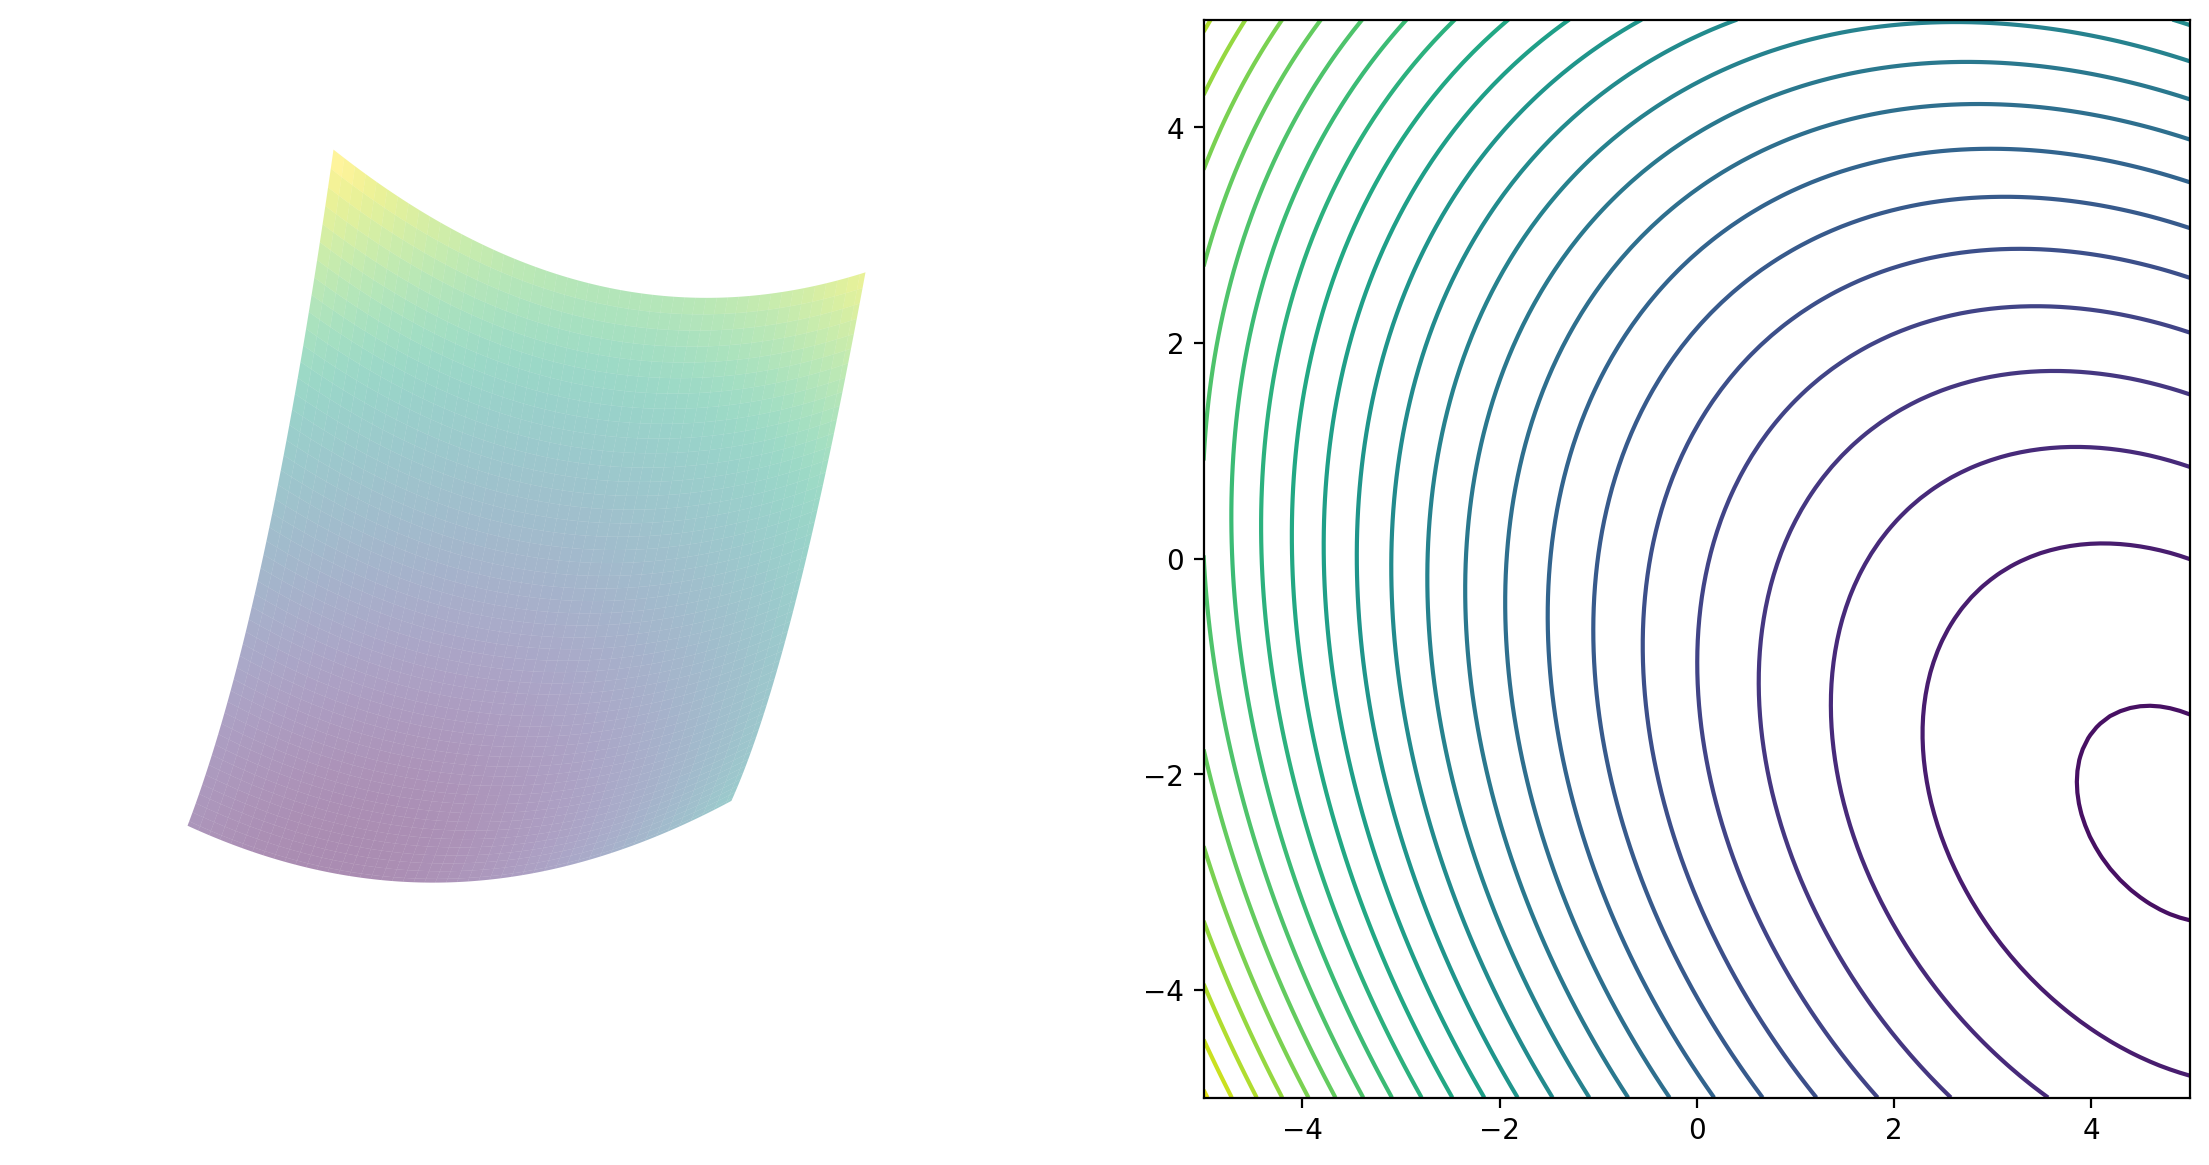

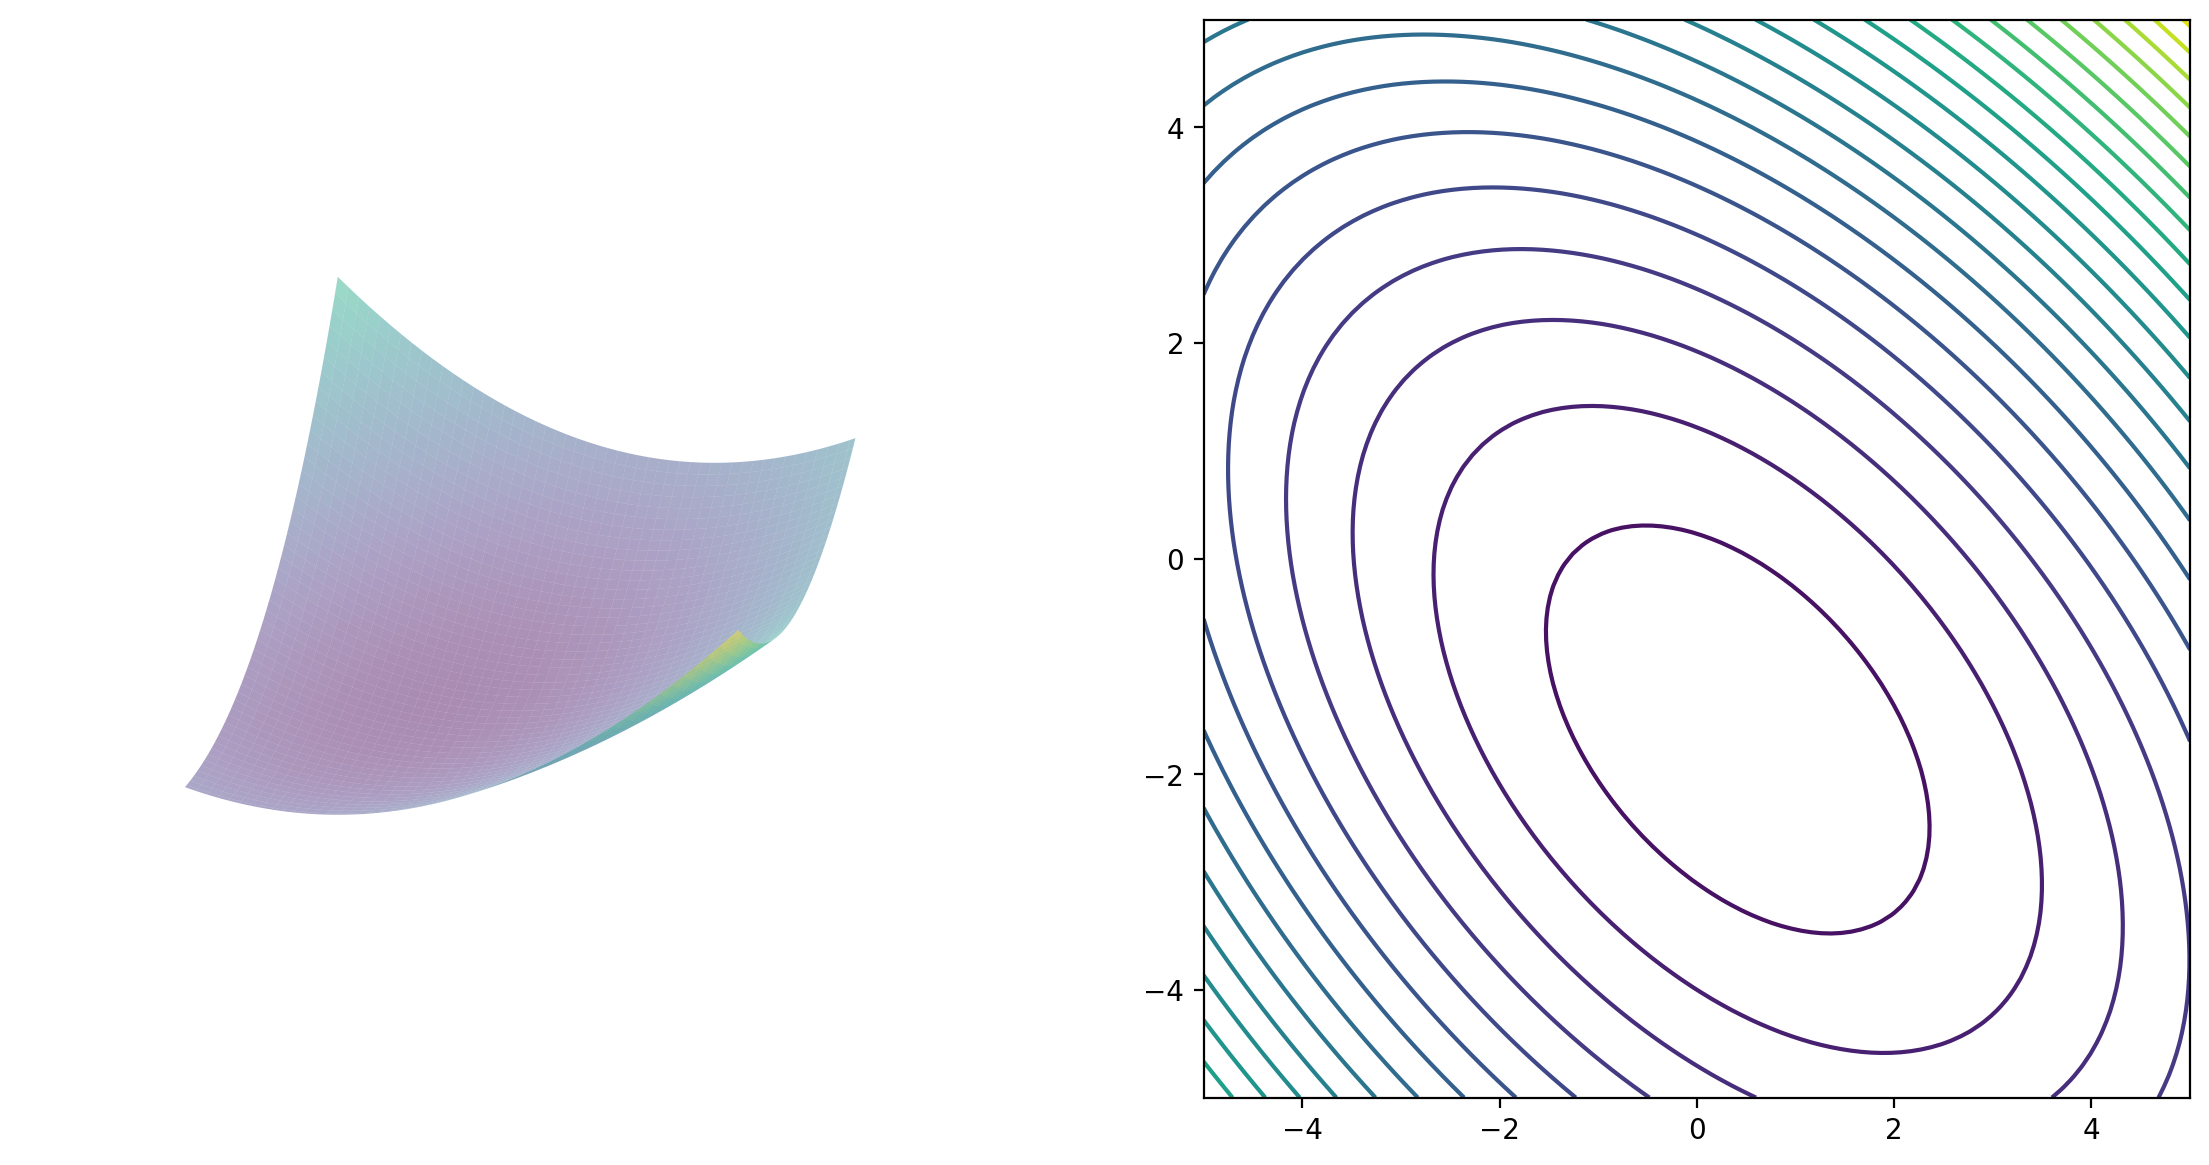

In [ ]:
fs = [generate_unimodal_function_with_global_min(2) for _ in range(2)]
for f in fs:
    plotter(f).figure().plot3d(radius=5)

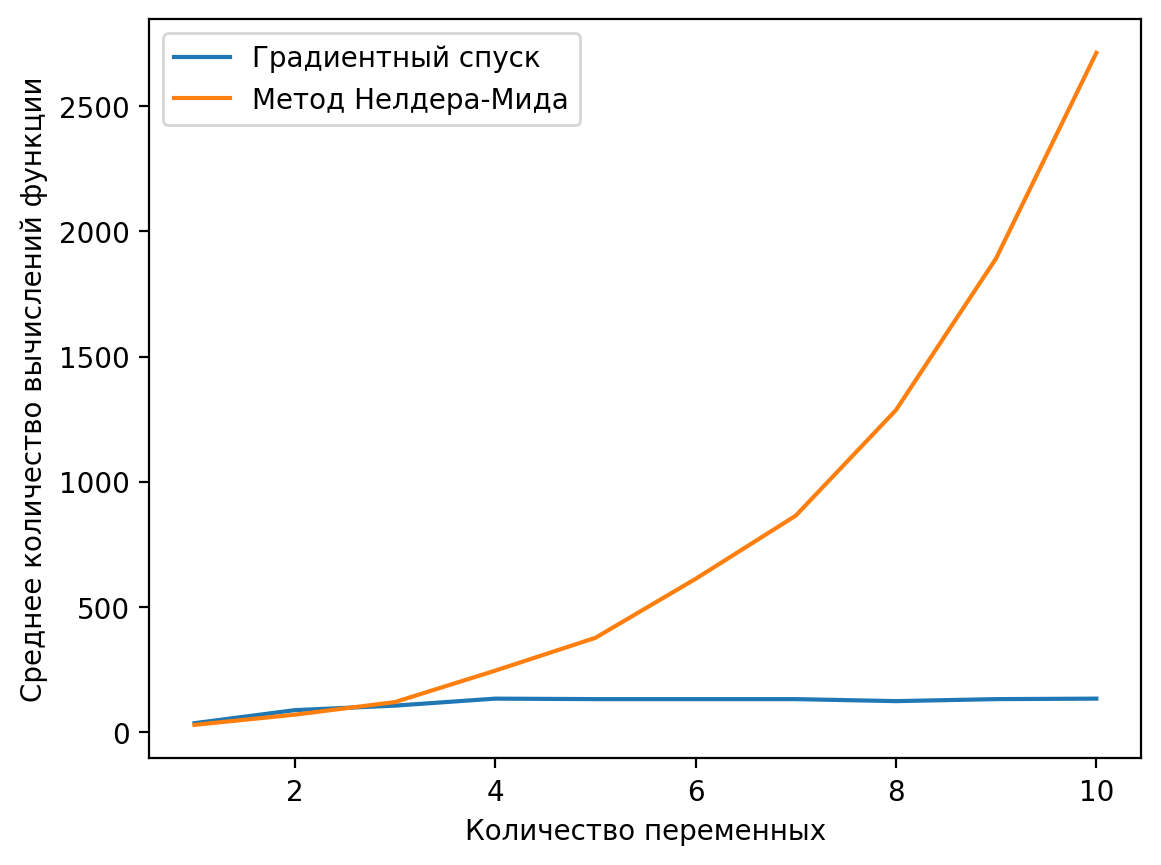

In [ ]:
functions = 3
points = 3
grad_iters = []
nm_iters = []
n_range = range(1, 10 + 1)
maxiter = 4000
eps = 1e-3

minimize_grad = partial(minimize.gradient, eps=eps, maxiter=maxiter)
minimize_nedler = partial(minimize.nelder_mead, eps=eps, maxiter=maxiter)

def average_calls(n, test_funcs, minimize_func):
    calls = 0
    for f in test_funcs:
        calls_for_func = 0
        for _ in range(points):
            point = [random.random() + 0.1 for _ in range(n)]
            point = np.array(point)
            point = point * (5 / np.linalg.norm(point))
            result = minimize_func(f, point)
            if not result.success():
                return float("inf")
            calls_for_func += result.calls
        calls += calls_for_func / points
    return calls / len(test_funcs)

def calls(n):
    fs = [generate_unimodal_function_with_global_min(n) for _ in range(functions)]
    seed = random.randint(0, 1000000)
    random.seed(seed)
    cg = average_calls(n, fs, minimize_grad)
    random.seed(seed)
    cn = average_calls(n, fs, minimize_nedler)
    return cg, cn

for n in n_range:
    cg, cn = calls(n)
    grad_iters.append(cg)
    nm_iters.append(cn)

plt.plot(n_range, grad_iters, label="Градиентный спуск")
plt.plot(n_range, nm_iters, label="Метод Нелдера-Мида")
plt.xlabel("Количество переменных")
plt.ylabel("Среднее количество вычислений функции")
plt.legend()

Мы сгенерировали 3 функции для каждого $n$ и подставили в каждую 3 случайные точки, затем нашли среднее значение вычислений функции.

Видно, что сложность Недлер Мида растёт в зависимости от $n$, в то время как сложность градиентного спуска почти не меняется.

Мы считаем, что это связано с тем, что в Недлер Миде число проверок на каждом симплексе зависит он $n$, а в спуске градиент по преждему вычисляется один раз на каждой итерации.

##### Исследование эффективности методов на плохо обусловленнных функциях двух переменных

В качестве примера возьмём функцию
$$ f(x, y) = (1 - x)^2 + 100(y - x^2)^2 $$

In [ ]:
f3 = sp.sympify("(1 - x)**2 + 100*(y - x**2)**2")
GLOBAL_MIN[f3] = np.array([1, 1])

|    | func                                                        | start point        | optimum            |   deviation |   iterations |   calls |    eps | method                                     |
|---:|:------------------------------------------------------------|:-------------------|:-------------------|------------:|-------------:|--------:|-------:|:-------------------------------------------|
|  0 | $\left(1 - x\right)^{2} + 100 \left(- x^{2} + y\right)^{2}$ | 3.50e+00, 1.00e+00 | 1.02e+00, 1.05e+00 |    0.0529   |         1338 |   30797 | 0.0001 | gradient with golden section stop by coord |
|  1 | $\left(1 - x\right)^{2} + 100 \left(- x^{2} + y\right)^{2}$ | 3.50e+00, 1.00e+00 | 1.00e+00, 1.00e+00 |    3.34e-05 |           61 |     112 | 0.0001 | nelder mead                                |

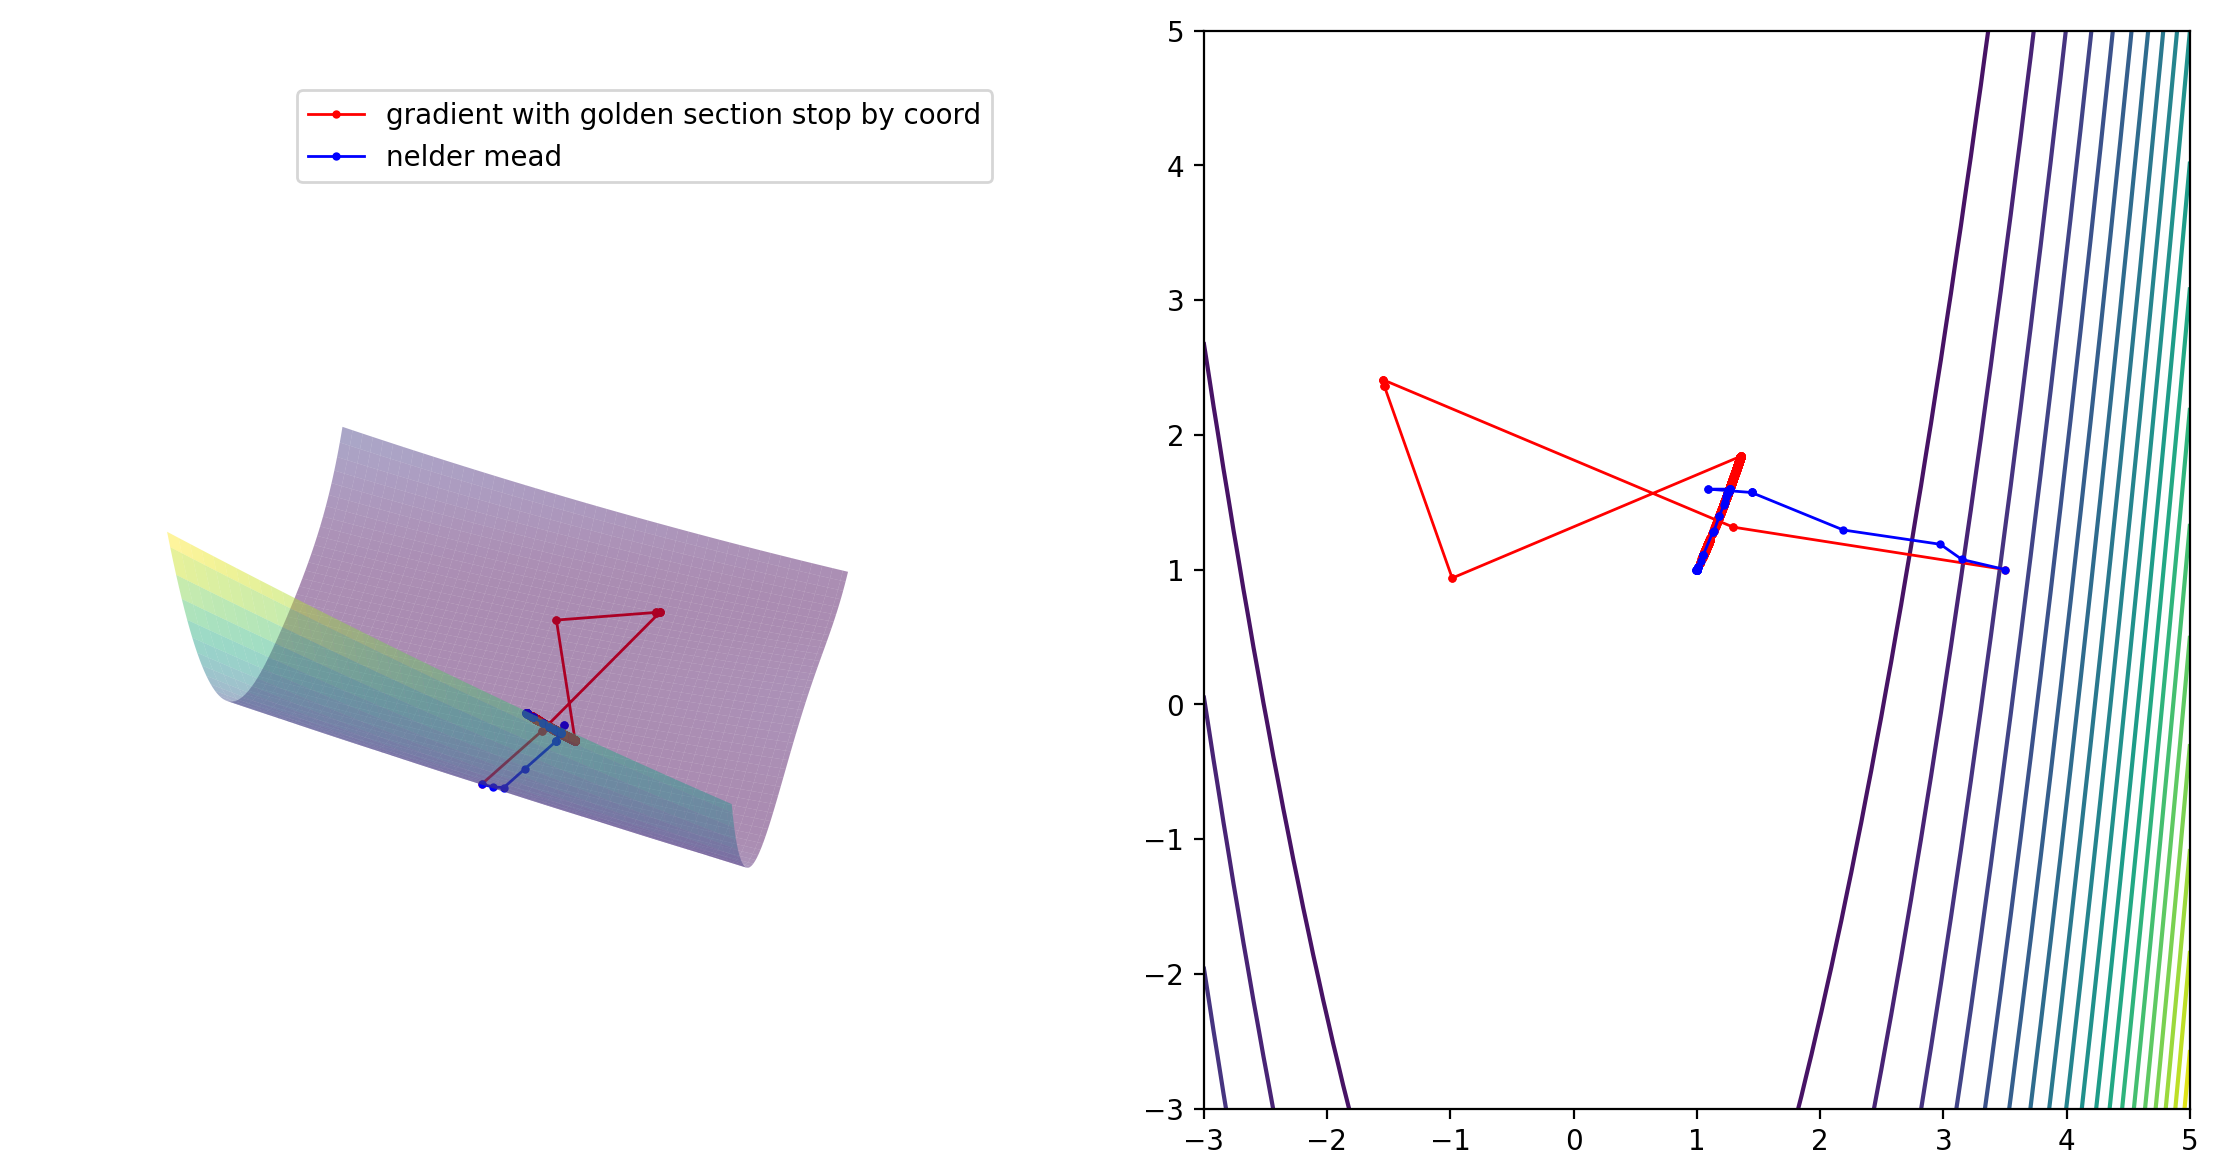

In [ ]:
eps = 0.0001
point = (3.5, 1)
center = tuple(GLOBAL_MIN[f3])

grad = minimize.gradient(f3, point, eps, maxiter=4000)
nm = minimize.nelder_mead(f3, point, eps, maxiter=4000)

plotter(f3).figure().plot3d(center=center, radius=4).plot_steps(
    grad.steps, l=grad.method, colors="red"
).plot_steps(nm.steps, l=nm.method, colors="blue")
Table().add_row(grad.row()).add_row(nm.row()).display()

Метод градиентного спуска с постоянным шагом на нашей функции не работатет, методы на основе одномерного поиска требуют большого числа итераций. Метод Нелдера-Мида работает оптимально.

##### Исследование эффективности методов на функциях с зашумлёнными значениями и на мультимодальных функциях

Возьмём мультимодальную функцию
$$f(x, y) = -20 \exp\left(-0.2 \sqrt{0.5(x^2 + y^2)}\right) - \exp\left(0.5 (\sin(2 \pi x) + \sin(2 \pi y))\right) + e + 20$$


In [ ]:
f4 = sp.sympify(
    "-20 * exp(-0.2 * (0.5 * sqrt(x ** 2 + y ** 2))) - exp(0.5 * (sin(2 * pi * x) + sin(2 * pi * y))) + exp(1) + 20"
)
GLOBAL_MIN[f4] = np.array([0, 0])

|    | func                                                                                                                   | start point   | optimum            |   deviation |   iterations |   calls |    eps | method                                     |
|---:|:-----------------------------------------------------------------------------------------------------------------------|:--------------|:-------------------|------------:|-------------:|--------:|-------:|:-------------------------------------------|
|  0 | $- e^{0.5 \sin{\left(2 \pi x \right)} + 0.5 \sin{\left(2 \pi y \right)}} + e + 20 - 20 e^{- 0.1 \sqrt{x^{2} + y^{2}}}$ | 2, 2          | 3.23e+00, 3.23e+00 |        4.57 |            1 |      46 | 0.0001 | gradient with golden section stop by coord |
|  1 | $- e^{0.5 \sin{\left(2 \pi x \right)} + 0.5 \sin{\left(2 \pi y \right)}} + e + 20 - 20 e^{- 0.1 \sqrt{x^{2} + y^{2}}}$ | 2, 2          | 2.23e+00, 2.23e+00 |        3.15 |           28 |      54 | 0.0001 | nelder mead                                |

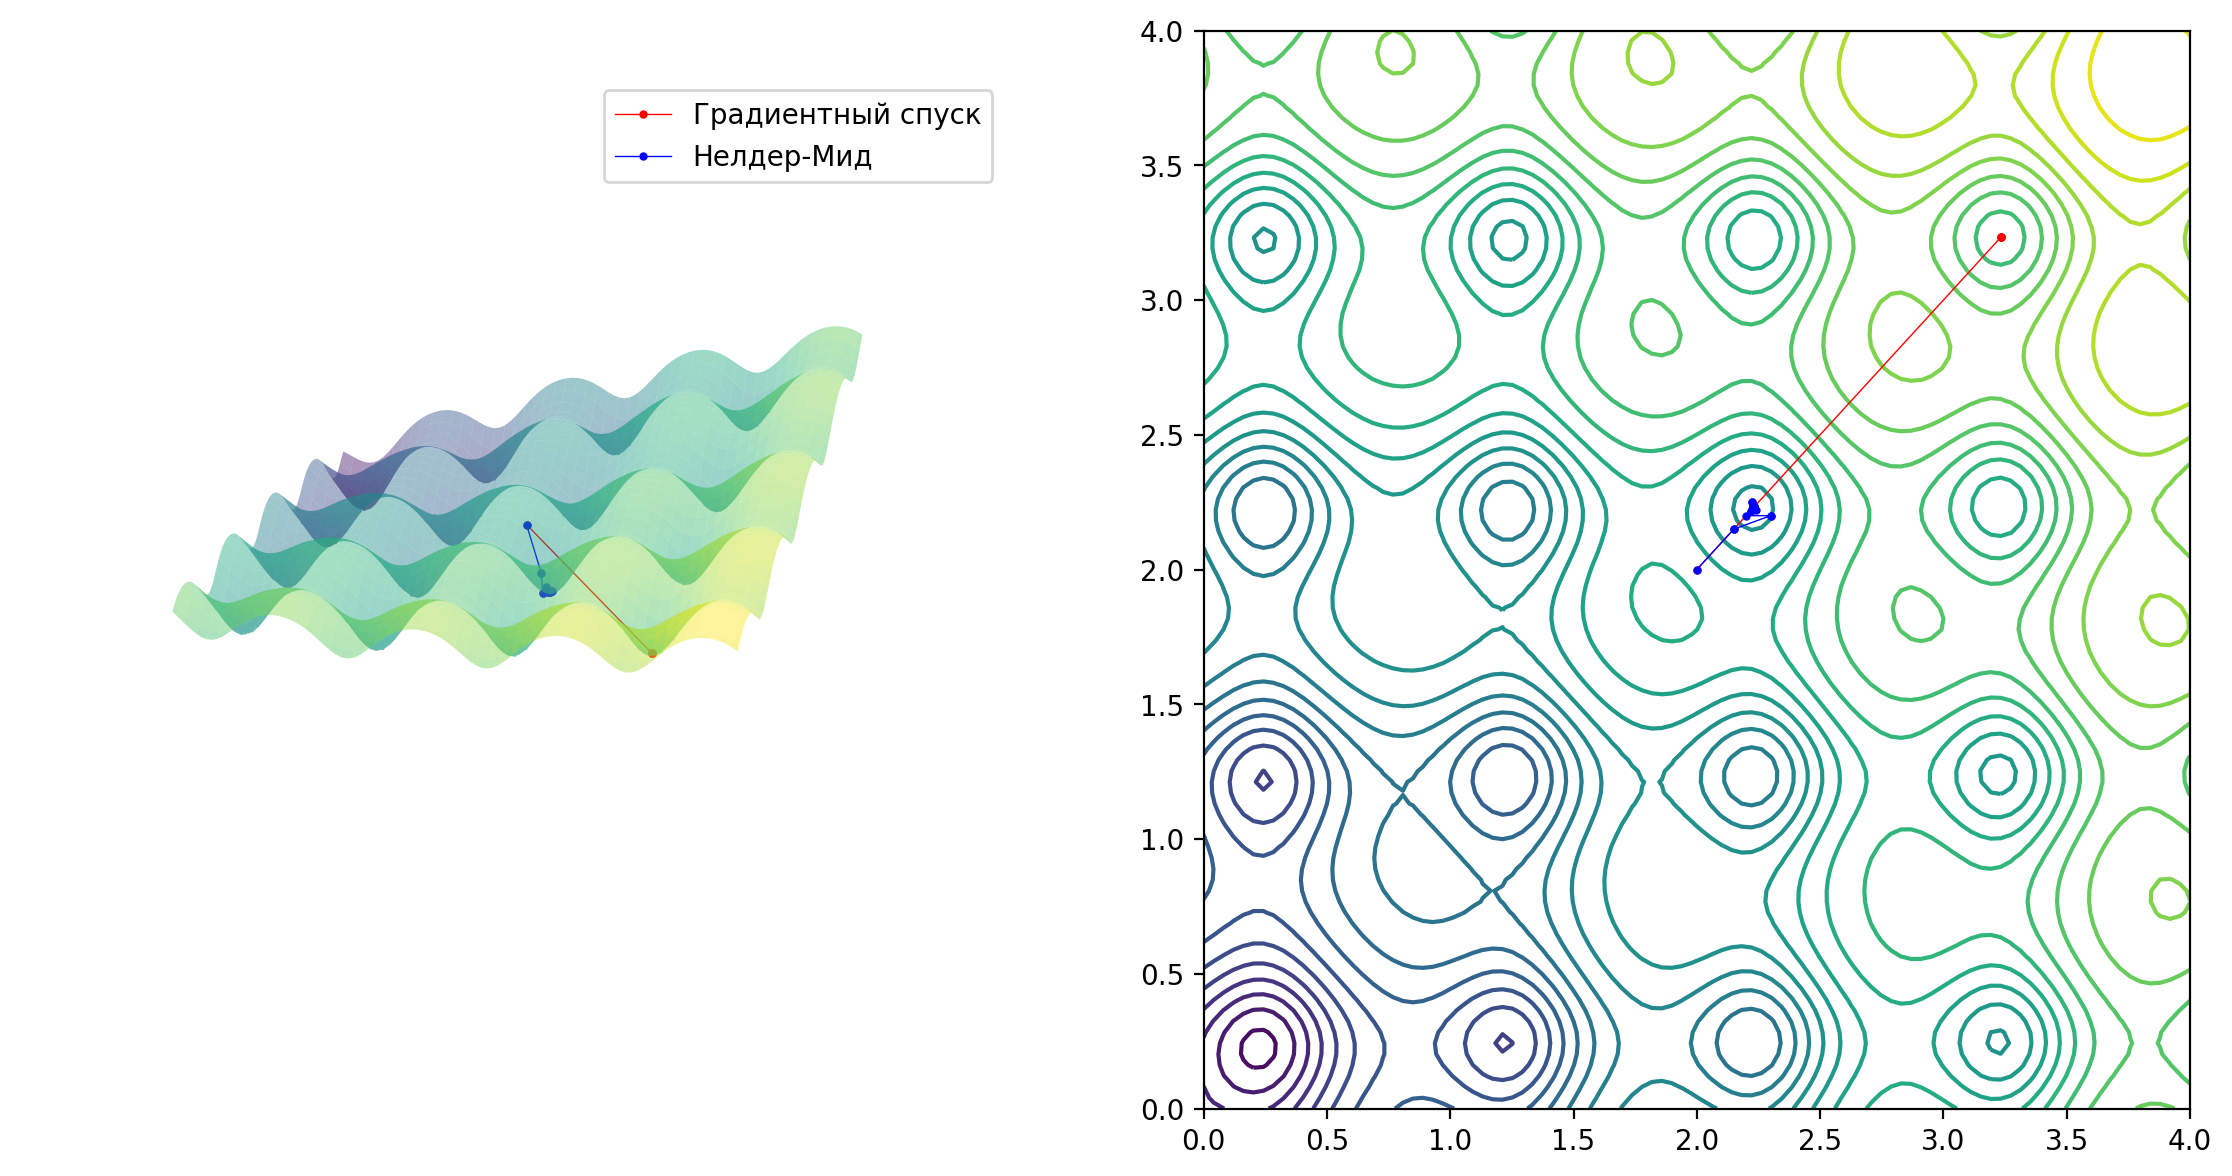

In [ ]:
gr = minimize.gradient(f4, (2, 2), eps)
nm = minimize.nelder_mead(f4, (2, 2), eps)

plotter(f4).figure().plot3d(center=(2, 2), radius=2).plot_steps(
    gr.steps, l=gr.method, colors="red"
).plot_steps(nm.steps, l=nm.method, colors="blue")

Table().add_row(gr.row()).add_row(nm.row()).display()

Мультимодальные функции имеют несколько локальных минимумов и максимумов, что делает поиск глобального оптимума более сложной задачей.

Градиентный спуск использует локальную информацию о градиенте функции для определения направления движения к минимуму.

Хотя метод Нелдера-Мида может быть менее чувствителен к локальным минимумам, чем градиентный спуск, он всё равно может застрять в них, если симплекс сокращается вокруг локального минимума до того, как глобальный минимум будет найден.

Возьмём зашумлённую функцию функцию

|    | func                                                                                 | start point   | optimum             |   deviation |   iterations |   calls |    eps | method                                     |
|---:|:-------------------------------------------------------------------------------------|:--------------|:--------------------|------------:|-------------:|--------:|-------:|:-------------------------------------------|
|  0 | $x^{2} + y^{2} - 4 \sin{\left(2 \pi x \right)} - 4 \cos{\left(2 \pi x \right)} + 10$ | -4, -4        | -3.84e+00, 1.62e-03 |        3.84 |           24 |     575 | 0.0001 | gradient with golden section stop by coord |
|  1 | $x^{2} + y^{2} - 4 \sin{\left(2 \pi x \right)} - 4 \cos{\left(2 \pi x \right)} + 10$ | -4, -4        | -3.84e+00, 3.16e-05 |        3.84 |           42 |      82 | 0.0001 | nelder mead                                |

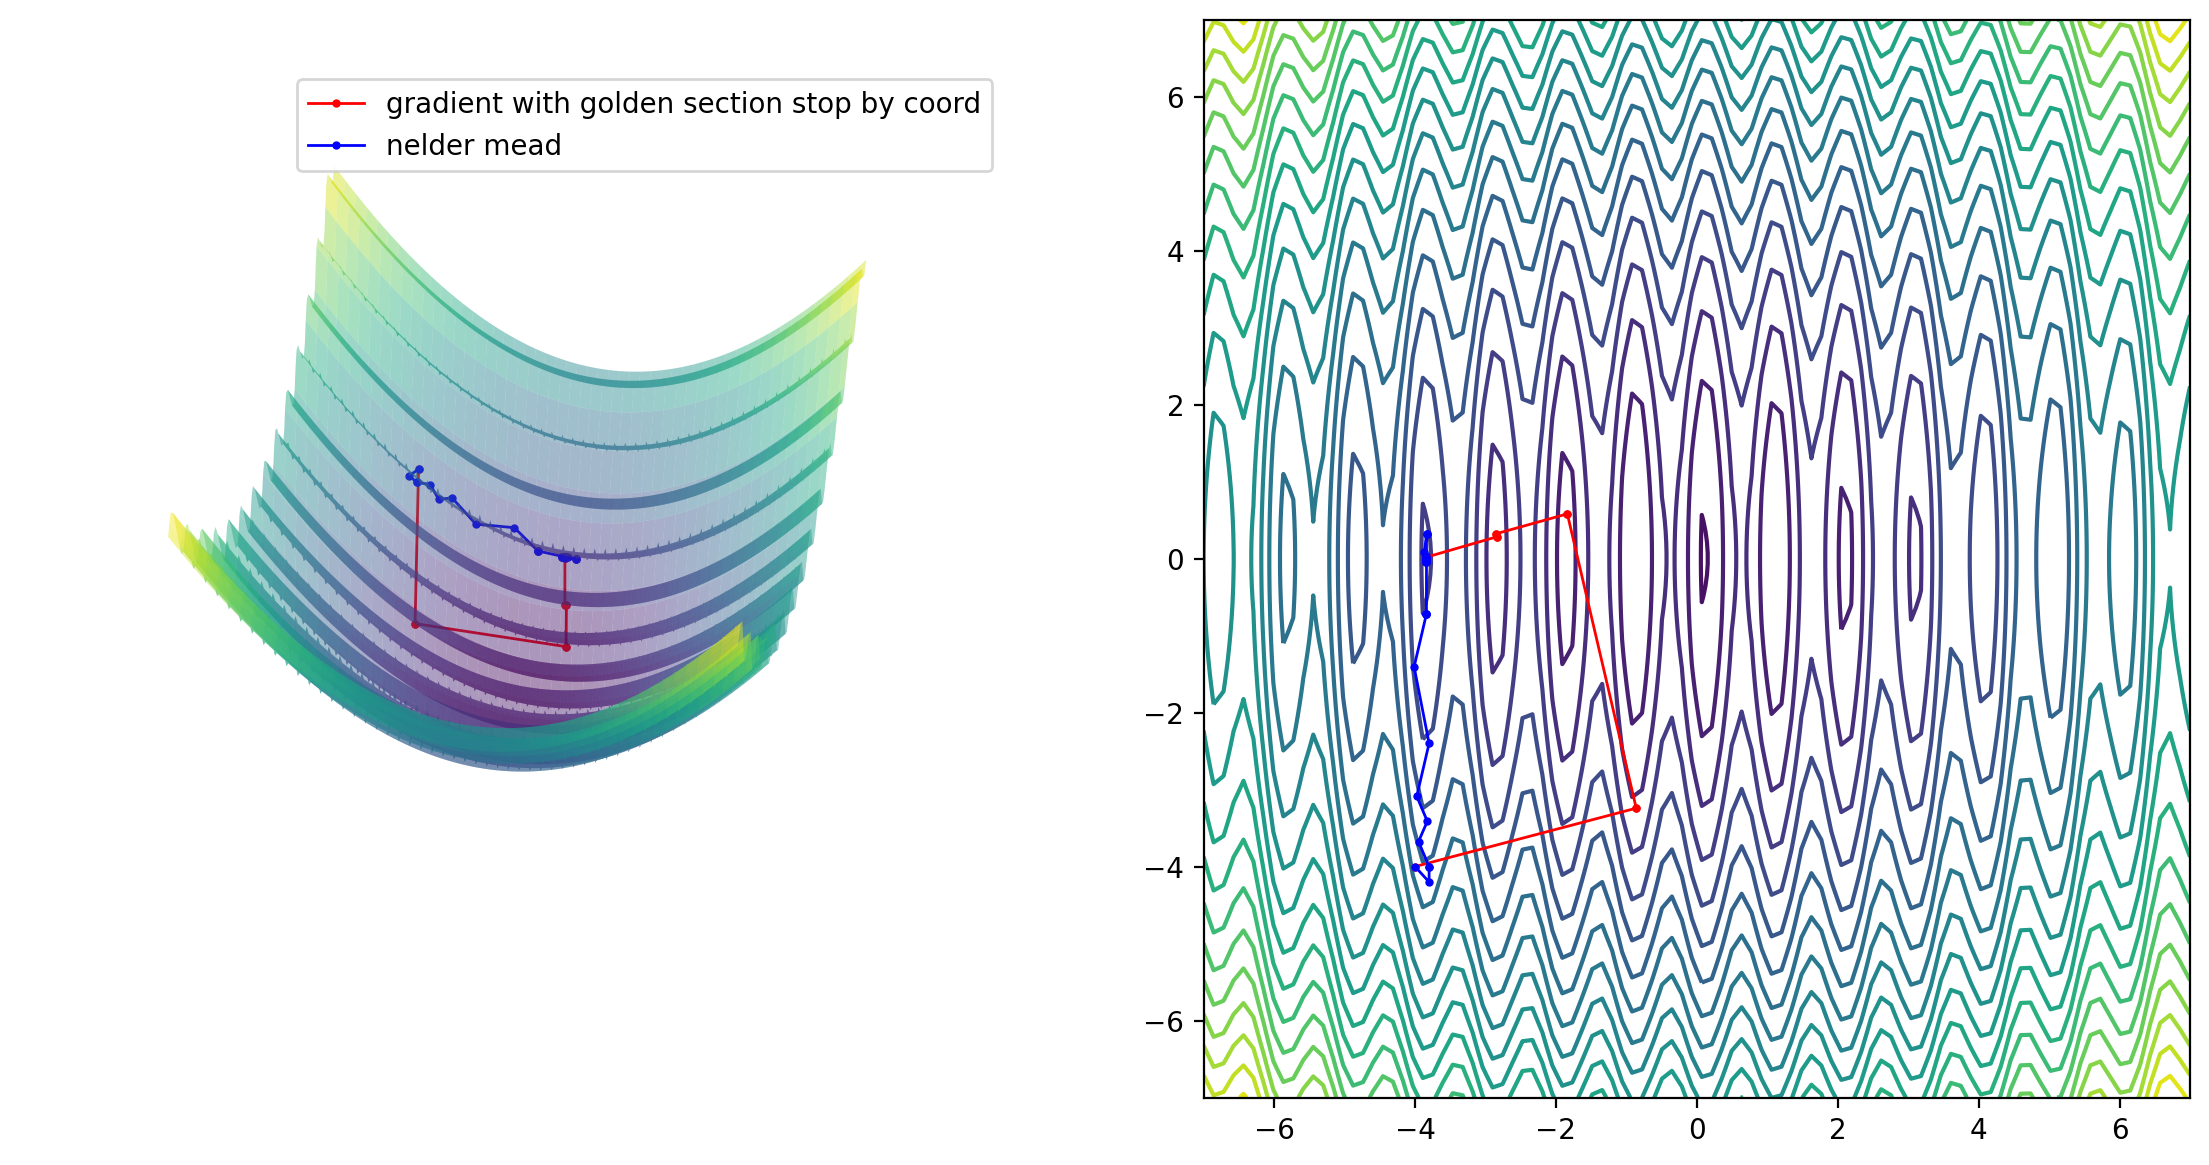

In [ ]:
f5 = sp.sympify("10 + x**2 + y**2 - 4*(cos(2*pi*x)+sin(2*pi*x))")
GLOBAL_MIN[f5] = np.array([0, 0])
gr = minimize.gradient(f5, (-4, -4), eps)
nm = minimize.nelder_mead(f5, (-4, -4), eps)

plotter(f5).figure().plot3d(radius=7).plot_steps(
    gr.steps, l=gr.method, colors="red"
).plot_steps(nm.steps, l=nm.method, colors="blue")

Table().add_row(gr.row()).add_row(nm.row()).display()

Градиентный спуск и Нелдер-Мид, сталкиваться с трудностями на зашумлённых функциях.

Шум в функции означает, что значения функции в точках близких друг к другу могут сильно различаться из-за случайных флуктуаций, что затрудняет определение направления к минимуму.

Шум может существенно исказить градиенты, делая их ненадёжными и заставляя алгоритм  перемещаться по кругу или застревать в локальных минимумах, которые являются артефактами шума.

Хотя метод Нелдера-Мида не зависит от градиентов, он тоже может застревать в локальных минимумах.


## Вывод

В результате нашего исследования мы на практике узнали сильные и слабые стороны разных методов оптимизации и выяснили, в каких ситуациях лучше применять каждый из них.